# Partie 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Extraction des données du site de NHL (Milestone 1)

In [2]:
import os
import json
import pandas as pd



class NHLPlayByPlayExtractor:
    
    def __init__(self, json_file):
        # Charger le fichier JSON
        with open(json_file, 'r', encoding='utf-8') as file:
            self.data = json.load(file)
        
    
    def extract_events(self):
        events_list = []
        
        # Extraire les informations du match
        game_id = self.data.get('id')
        season = self.data.get('season')
        team_home_Id = self.data['homeTeam']['id']
        team_away_Id = self.data['awayTeam']['id']
        team_home = self.data['homeTeam']['name']['default']
        team_away = self.data['awayTeam']['name']['default']
        
        # Extraire les actions pertinentes (uniquement les tirs et les buts)
        plays = self.data.get('plays', [])
        for play in plays:
            event_type = play['typeDescKey']

            
            # Inclure uniquement les événements "Tir au but" et "But"
            if event_type in ['shot-on-goal', 'goal']:
                event_id = play.get('eventId', 'Unknown')  # Extraction de l'event_id555
                period = play['periodDescriptor']['number']
                period_time = play['timeInPeriod']
                details = play.get('details', {})
                eventTeamId=details.get('eventOwnerTeamId', None)
                coordinate_x = details.get('xCoord', None)
                coordinate_y = details.get('yCoord', None)
                event_team = team_home if eventTeamId== self.data['homeTeam']['id'] else team_away
                home_team_defending_side = play.get('homeTeamDefendingSide', None)
                zone_code = details.get('zoneCode', None)
                

                
                # Extraire la situation du champ situationCode


                # Extraction du situationCode et des informations pertinentes
                situation_code = play.get('situationCode', None)

                if situation_code:
                  away_goalie = situation_code[0]  # 1 ou 0 pour le gardien extérieur
                  away_skaters = int(situation_code[1])  # Nombre de joueurs extérieurs
                  home_skaters = int(situation_code[2])  # Nombre de joueurs à domicile
                  home_goalie = situation_code[3]  # 1 ou 0 pour le gardien à domicile

                # Calcul de empty_net
                  if eventTeamId== self.data['awayTeam']['id']:
                    # L'équipe qui effectue l'événement est l'équipe extérieure
                    if home_goalie == '1':
                       empty_net = 0  # Le gardien de l'équipe à domicile est dans son filet
                    else:
                       empty_net = 1  # Le gardien de l'équipe à domicile a quitté son filet
                  elif eventTeamId == self.data['homeTeam']['id']:
                      # L'équipe qui effectue l'événement est l'équipe à domicile
                    if away_goalie == '1':
                       empty_net = 0  # Le gardien de l'équipe extérieure est dans son filet
                    else:
                       empty_net = 1  # Le gardien de l'équipe extérieure a quitté son filet
                  else:
                      empty_net = None  # Cas non traité

               # Calcul de strength
                  if eventTeamId == self.data['awayTeam']['id']:
                  # Équipe extérieure effectue l'événement
                    if away_skaters > home_skaters:
                      strength = "PP"  # Avantage numérique (power play) pour l'équipe extérieure
                    elif away_skaters < home_skaters:
                      strength = "SH"  # Désavantage numérique (short-handed) pour l'équipe extérieure
                    else:
                      strength = "EV"  # Forces égales
                  elif eventTeamId == self.data['homeTeam']['id']:
                 # Équipe à domicile effectue l'événement
                    if home_skaters > away_skaters:
                      strength = "PP"  # Avantage numérique pour l'équipe à domicile
                    elif home_skaters < away_skaters:
                       strength = "SH"  # Désavantage numérique pour l'équipe à domicile
                    else:
                      strength = "EV"  # Forces égales
                  else:
                    strength = None  # Cas non traité
                else:
                  empty_net = None
                  strength = None

                
                # Ajouter les informations extraites à la liste des événements
                events_list.append([
                    game_id, season, team_home_Id,team_home,team_away_Id, team_away, event_id,event_type, eventTeamId,event_team,zone_code, period,
                    period_time, coordinate_x, coordinate_y, empty_net, strength
                ])
        
        
      

        # Créer un DataFrame à partir de la liste des événements
        columns = [
            'gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId','teamAway', 'event_id','eventType','eventTeamId','eventTeam', 'zoneCode',
            'period', 'periodTime', 'coordinateX', 'coordinateY', 'emptyNet', 'strength'
        ] 

        return pd.DataFrame(events_list, columns=columns)
    
    
    
    @staticmethod
    def clean_data(folder_path):
        all_events = []  # Liste pour stocker les événements de tous les fichiers
    
        # Obtenir tous les fichiers JSON dans le répertoire
        json_files = sorted(filter(lambda x: x.endswith('.json'), os.listdir(folder_path)))
    
        for filename in json_files:
            file_path = os.path.join(folder_path, filename)
            print(f"Traitement du fichier : {file_path}")
        
            try:
                # Passer les noms des joueurs lors de la création d'une instance de NHLPlayByPlayExtractor
                extractor = NHLPlayByPlayExtractor(file_path)
                df = extractor.extract_events()
                all_events.append(df)
            except Exception as e:
                print(f"Erreur lors du traitement du fichier {file_path} : {e}")
    
        # Combiner tous les DataFrames en un seul
        if all_events:
            final_df = pd.concat(all_events, ignore_index=True)
            return final_df
        else:
            return pd.DataFrame()  # Retourner un DataFrame vide s'il n'y a pas d'événements


json_directory_path = '../data/nhl_data/'
df2 = NHLPlayByPlayExtractor.clean_data(json_directory_path)

# Afficher le DataFrame combiné
print(df2)



Traitement du fichier : ../data/nhl_data/2016020001.json
Traitement du fichier : ../data/nhl_data/2016020002.json
Traitement du fichier : ../data/nhl_data/2016020003.json
Traitement du fichier : ../data/nhl_data/2016020004.json
Traitement du fichier : ../data/nhl_data/2016020005.json
Traitement du fichier : ../data/nhl_data/2016020006.json
Traitement du fichier : ../data/nhl_data/2016020007.json
Traitement du fichier : ../data/nhl_data/2016020008.json
Traitement du fichier : ../data/nhl_data/2016020009.json
Traitement du fichier : ../data/nhl_data/2016020010.json
Traitement du fichier : ../data/nhl_data/2016020011.json
Traitement du fichier : ../data/nhl_data/2016020012.json
Traitement du fichier : ../data/nhl_data/2016020013.json
Traitement du fichier : ../data/nhl_data/2016020014.json
Traitement du fichier : ../data/nhl_data/2016020015.json
Traitement du fichier : ../data/nhl_data/2016020016.json
Traitement du fichier : ../data/nhl_data/2016020017.json
Traitement du fichier : ../data

In [7]:
# Afficher les valeurs uniques de la colonne 'eventType'
print(df2['eventType'].unique())

['shot-on-goal' 'goal']


In [8]:
# Vérifier s'il y a des NaN dans df2
if df2.isna().any().any():
    print("Il y a des valeurs NaN dans df2.")
else:
    print("Aucune valeur NaN dans df2.")

# Nombre de valeurs NaN dans chaque colonne
nans_per_column = df2.isna().sum()
print("Nombre de valeurs NaN par colonne :")
print(nans_per_column)

Il y a des valeurs NaN dans df2.
Nombre de valeurs NaN par colonne :
gameId          0
season          0
teamHomeId      0
teamHome        0
teamAwayId      0
teamAway        0
event_id        0
eventType       0
eventTeamId     0
eventTeam       0
zoneCode       14
period          0
periodTime      0
coordinateX    16
coordinateY    15
emptyNet        0
strength        0
dtype: int64


In [9]:
print(df2.shape[0])

647679


In [10]:
# Supprimer les lignes contenant des NaN dans les colonnes 'coordinateX' ou 'coordinateY'
df2 = df2.dropna(axis=0, subset=['coordinateX', 'coordinateY'])

# Réinitialiser l'index après suppression des lignes
df2 = df2.reset_index(drop=True)

# Afficher un message pour confirmer le nettoyage
print(f"Nettoyage terminé. Nombre de lignes restantes : {len(df2)}")

Nettoyage terminé. Nombre de lignes restantes : 647662


In [11]:
# Vérifier s'il y a des NaN dans df2
if df2.isna().any().any():
    print("Il y a des valeurs NaN dans df2.")
else:
    print("Aucune valeur NaN dans df2.")

# Nombre de valeurs NaN dans chaque colonne
nans_per_column = df2.isna().sum()
print("Nombre de valeurs NaN par colonne :")
print(nans_per_column)

Aucune valeur NaN dans df2.
Nombre de valeurs NaN par colonne :
gameId         0
season         0
teamHomeId     0
teamHome       0
teamAwayId     0
teamAway       0
event_id       0
eventType      0
eventTeamId    0
eventTeam      0
zoneCode       0
period         0
periodTime     0
coordinateX    0
coordinateY    0
emptyNet       0
strength       0
dtype: int64


## Calcul de la la distance et de l'angle par rapport au net

In [12]:
import math
import pandas as pd
import numpy as np

def calcul_distance_angle(df):
   # Initialiser la liste des distances et le dictionnaire des côtés défensifs par période pour chaque ligne
    distances = []
    home_defending_side_period = {1: None, 2: None, 3: None}

    # Boucler sur chaque ligne pour calculer les distances
    for index, row in df.iterrows():
        # Initialiser la distance à None pour chaque ligne
        distance = None

        # Extraire les informations pertinentes
        x = row['coordinateX']
        y = row['coordinateY']
        event_team_id = row['eventTeamId']
        home_team_id = row['teamHomeId']
        defending_side = row.get('homeTeamDefendingSide', None)
        zone_code = row.get('zoneCode', None)
        period = row.get('period', None)
        season = row.get('season', None)

       # Initialiser la liste des distances et le dictionnaire des côtés défensifs par période
    angles = []
    home_defending_side_period = {1: None, 2: None, 3: None}
    
    # Boucler sur chaque ligne pour calculer les distances
    
    for index, row in df.iterrows():
        # Initialiser la distance à None pour chaque ligne
        angle = None

        # Extraire les informations pertinentes
        x = row['coordinateX']
        y = row['coordinateY']
        event_team_id = row['eventTeamId']
        home_team_id = row['teamHomeId']
        defending_side = row.get('homeTeamDefendingSide', None)
        zone_code = row.get('zoneCode', None)
        period = row.get('period', None)
        season = row.get('season', None)

        # Vérifier la saison et définir les conditions de calcul
        if  zone_code is not None:
            if event_team_id == home_team_id and period in home_defending_side_period:
                if home_defending_side_period[period] is None:
                    home_defending_side_period[period] = 'right' if x > 0 else 'left'
        
            if zone_code == "D":
                if x > 0:
                    distance = math.sqrt((x + 89)**2 + y**2)
                    angle = np.arctan2(y,(x+89))
                elif x < 0:
                    distance = math.sqrt((89 - x)**2 + y**2)
                    angle = np.arctan2(y,(89-x))
            elif zone_code == "O":
                if x > 0:
                    distance = math.sqrt((89 - x)**2 + y**2)
                    angle=np.arctan2(y,(89-x))
                elif x < 0:
                    distance = math.sqrt((x + 89)**2 + y**2)
                    angle= np.arctan2(y,(x+89))
            elif zone_code == "N" and period in home_defending_side_period: 
                if event_team_id == home_team_id:
                    if home_defending_side_period[period] == 'right':
                        distance = math.sqrt((x + 89)**2 + y**2)
                        angle= np.arctan2(y,(x+89))
                    elif home_defending_side_period[period] == 'left':
                        distance = math.sqrt((89 - x)**2 + y**2)
                        angle= np.arctan2(y,(89-x))
                else:
                    if home_defending_side_period[period] == 'right':
                        distance = math.sqrt((89 - x)**2 + y**2)
                        angle= np.arctan2(y,(89-x))
                    elif home_defending_side_period[period] == 'left':
                        distance = math.sqrt((x + 89)**2 + y**2)
                        angle= np.arctan2(y,(x+89))
        
        if angle is not None:
            angle = round(np.rad2deg(angle), 4)

        distances.append(distance)
        angles.append(angle)

    # Ajouter les distances calculées au DataFrame
    df['distance'] = distances
    df['distance_round'] = df['distance'].round(0)


    # Ajouter les distances calculées au DataFrame
    df['angle'] = angles
    
    return df


# Calculer les distances pour toutes les saisons
df2 = calcul_distance_angle(df2)

# Afficher le DataFrame mis à jour
print(df2.head())

       gameId    season  teamHomeId  teamHome  teamAwayId     teamAway  \
0  2016020001  20162017           9  Senators          10  Maple Leafs   
1  2016020001  20162017           9  Senators          10  Maple Leafs   
2  2016020001  20162017           9  Senators          10  Maple Leafs   
3  2016020001  20162017           9  Senators          10  Maple Leafs   
4  2016020001  20162017           9  Senators          10  Maple Leafs   

   event_id     eventType  eventTeamId    eventTeam zoneCode  period  \
0         8  shot-on-goal           10  Maple Leafs        O       1   
1        11  shot-on-goal            9     Senators        O       1   
2        15  shot-on-goal            9     Senators        N       1   
3        16  shot-on-goal            9     Senators        O       1   
4        24  shot-on-goal           10  Maple Leafs        O       1   

  periodTime  coordinateX  coordinateY  emptyNet strength    distance  \
0      01:11        -77.0          5.0         0 

In [13]:
# Afficher les valeurs uniques de la colonne 'eventType'
print(df2['eventType'].unique())

['shot-on-goal' 'goal']


In [14]:
# Vérifier s'il y a des NaN dans df2
if df2.isna().any().any():
    print("Il y a des valeurs NaN dans df2.")
else:
    print("Aucune valeur NaN dans df2.")

# Nombre de valeurs NaN dans chaque colonne
nans_per_column = df2.isna().sum()
print("Nombre de valeurs NaN par colonne :")
print(nans_per_column)

Il y a des valeurs NaN dans df2.
Nombre de valeurs NaN par colonne :
gameId              0
season              0
teamHomeId          0
teamHome            0
teamAwayId          0
teamAway            0
event_id            0
eventType           0
eventTeamId         0
eventTeam           0
zoneCode            0
period              0
periodTime          0
coordinateX         0
coordinateY         0
emptyNet            0
strength            0
distance            0
distance_round      0
angle             118
dtype: int64


In [15]:
# Supprimer les lignes contenant des NaN dans les colonnes 'coordinateX' ou 'coordinateY'
df2 = df2.dropna(axis=0, subset=['angle'])

# Réinitialiser l'index après suppression des lignes
df2 = df2.reset_index(drop=True)

# Afficher un message pour confirmer le nettoyage
print(f"Nettoyage terminé. Nombre de lignes restantes : {len(df2)}")

Nettoyage terminé. Nombre de lignes restantes : 647544


In [16]:
# Enregistrer éventuellement dans un fichier CSV
df2.to_csv('../data/Milestone2_data/Q2_data.csv', index=False)

In [17]:
# Ajouter ou mettre à jour la colonne 'isGoal'
df2['isGoal'] = df2['eventType'].apply(lambda x: 1 if x == 'goal' else 0)

# Afficher les premières lignes pour vérifier le résultat
print(df2[['eventType', 'isGoal']].head())

      eventType  isGoal
0  shot-on-goal       0
1  shot-on-goal       0
2  shot-on-goal       0
3  shot-on-goal       0
4  shot-on-goal       0


Verifier que tous els eventype='goal' ont isGoal=1

In [18]:
# Filtrer les lignes où eventType == 'goal'
goals = df2[df2['eventType'] == 'goal']

# Vérifier que isGoal == 1 pour ces lignes
if (goals['isGoal'] == 1).all():
    print("Tous les 'goal' ont 'isGoal' égal à 1.")
else:
    print("Il y a des 'goal' où 'isGoal' n'est pas égal à 1.")

Tous les 'goal' ont 'isGoal' égal à 1.


## Preparation de la data nécaessaire pour le traitement ici

In [19]:
gameID=df2['gameId']
distance= df2['distance']
angle= df2['angle']
isGoal = df2['isGoal']
emptyNet = df2['emptyNet']

# Save the lists into a new dataframe
data = pd.DataFrame({'gameID': gameID,
                     'distance': distance ,
                     'angle': angle,
                     'isGoal': isGoal,
                     'emptyNet': emptyNet
                    })

# Filtrer les données où isGoal est égal à 1
data_goals = data[data['isGoal'] == 1]

# Afficher les dernières lignes de ce DataFrame filtré
print(data_goals.tail())

            gameID    distance    angle  isGoal  emptyNet
647495  2023030416   71.847060 -34.7960       1         1
647497  2023030416  153.081678   1.8717       1         1
647502  2023030417    8.485281 -45.0000       1         0
647503  2023030417   12.165525  -9.4623       1         0
647529  2023030417   37.483330 -43.9191       1         0


In [20]:
data['emptyNet'].isna().any()

np.False_

## Repartition des données en test et apprentissage:

In [21]:
# Assurez-vous que 'gameID' est de type string
data['gameID'] = data['gameID'].astype(str)

# Maintenant, divisez les données en ensembles d'entraînement et de test
train_data = data[(data['gameID'].str[:4] == '2016') | 
                  (data['gameID'].str[:4] == '2017') | 
                  (data['gameID'].str[:4] == '2018') | 
                  (data['gameID'].str[:4] == '2019')]

test_data = data[data['gameID'].str[:4] == '2020']

Verifier que les variables contiennent les bonnes saisons

In [22]:
#Check that train data contains only the right seasons
print(f'train data:')
print(train_data['gameID'].str[:4].unique())
#Check that test data contains only the right seasons
print(f'test data: ')
print(test_data['gameID'].str[:4].unique())

train data:
['2016' '2017' '2018' '2019']
test data: 
['2020']


In [23]:
print(df2.columns)

Index(['gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId', 'teamAway',
       'event_id', 'eventType', 'eventTeamId', 'eventTeam', 'zoneCode',
       'period', 'periodTime', 'coordinateX', 'coordinateY', 'emptyNet',
       'strength', 'distance', 'distance_round', 'angle', 'isGoal'],
      dtype='object')


Sauvegarde de la donnée de la question 2 dans fichiers

In [24]:
# Export train_data and test_data as csv
train_data.to_csv('../data/Milestone2_data/Q2_train_data.csv')
test_data.to_csv('../data/Milestone2_data/Q2_test_data.csv')
df2.to_csv('../data/Milestone2_data/Q2_data.csv', index=False)  # Data comprenant aussi les angles et les distances

In [25]:
train_data

,gameID,distance,angle,isGoal,emptyNet
0,2016020001,13.000000,22.6199,0,0
1,2016020001,13.341664,77.0054,0,0
2,2016020001,118.270876,-18.7413,0,0
3,2016020001,57.974132,-14.9951,0,0
4,2016020001,61.717096,26.9802,0,0
...,...,...,...,...,...
327249,2019030416,38.418745,-38.6598,0,0
327250,2019030416,8.544004,20.5560,0,0
327251,2019030416,55.326305,-6.2258,0,0
327252,2019030416,58.855756,9.7824,0,0


In [26]:
test_data

,gameID,distance,angle,isGoal,emptyNet
327254,2020020001,32.649655,62.6501,0,0
327255,2020020001,47.169906,-32.0054,0,0
327256,2020020001,48.270074,-39.9575,0,0
327257,2020020001,60.307545,40.2921,0,0
327258,2020020001,36.878178,12.5288,0,0
...,...,...,...,...,...
384971,2020030415,43.863424,43.1524,0,0
384972,2020030415,45.276926,-43.2101,0,0
384973,2020030415,46.173586,-17.6501,0,0
384974,2020030415,12.369317,-14.0362,0,0


In [27]:
if (test_data['isGoal'] == 1).any():
    print("Il existe des lignes dans 'test_data' où 'isGoal' est égal à 1.")
    print("Nombre total : ", test_data[test_data['isGoal'] == 1].shape[0])
else:
    print("Aucune ligne dans 'test_data' où 'isGoal' est égal à 1.")

Il existe des lignes dans 'test_data' où 'isGoal' est égal à 1.
Nombre total :  5636


- Un histogramme du nombre de tirs (buts et non-buts séparés), regroupées (binned) par distance
- Un histogramme de nombre de tirs (buts et non-buts séparés), binned par angle
- Un histogramme 2D où un axe est la distance et l'autre est l'angle. Vous n'avez pas besoin de séparer les buts et les non-buts.


### Histogramme du nombre de tirs (buts et non-buts séparés) regroupés (binned) par distance

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

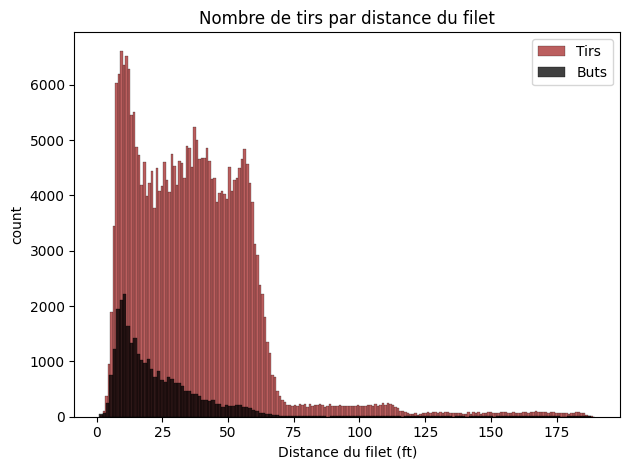

In [32]:
sns.histplot(data=train_data[train_data['isGoal'] ==0], x='distance', color = 'brown', label = 'Tirs').set(xlabel='Distance du filet (ft)', ylabel='count')
sns.histplot(data=train_data[train_data['isGoal'] ==1], x='distance', color = 'black', label = 'Buts')
plt.legend()
plt.title("Nombre de tirs par distance du filet")
plt.tight_layout()
plt.savefig('../figures/Milestone_2/2-1a_dist_from_net.png')

### Histogramme de nombre de tirs (buts et non-buts séparés), binned par angle

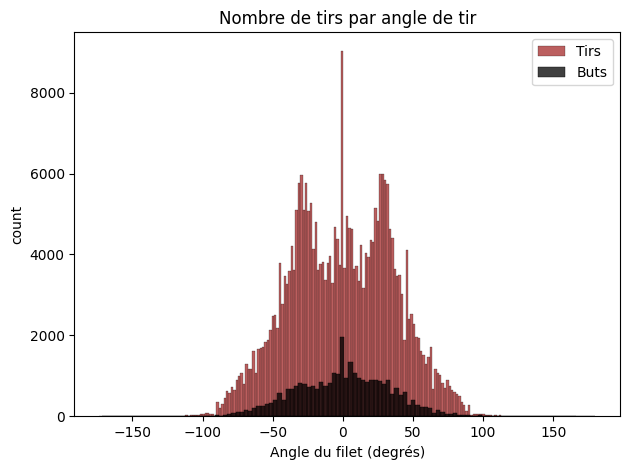

In [33]:
sns.histplot(data=train_data[train_data['isGoal'] ==0], x='angle', color = 'brown', label = 'Tirs').set(xlabel='Angle du filet (degrés)', ylabel='count')
sns.histplot(data=train_data[train_data['isGoal'] ==1], x='angle', color = 'black', label = 'Buts')
plt.legend()
plt.title("Nombre de tirs par angle de tir")
plt.tight_layout()
plt.savefig('../figures/Milestone_2/2-1b_angle_from_net.png')

### Histogramme 2D où un axe est la distance et l'autre est l'angle

_Vour possibilités dans https://seaborn.pydata.org/generated/seaborn.jointplot.html_

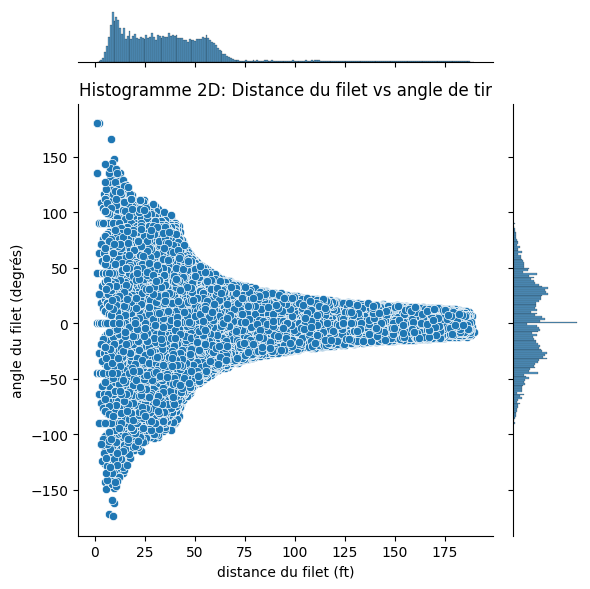

In [39]:
# Set labels directly with `set_axis_labels()` method
sns.jointplot(data=train_data, x="distance", y="angle") \
    .set_axis_labels("distance du filet (ft)", "angle du filet (degrés)")
plt.title("Histogramme 2D: Distance du filet vs angle de tir")
plt.tight_layout()
plt.savefig('../figures/Milestone_2/hist_2d_distance_vs_angle.png')

## Autres histogrammes 2D où un axe est la distance et l'autre est l'angle

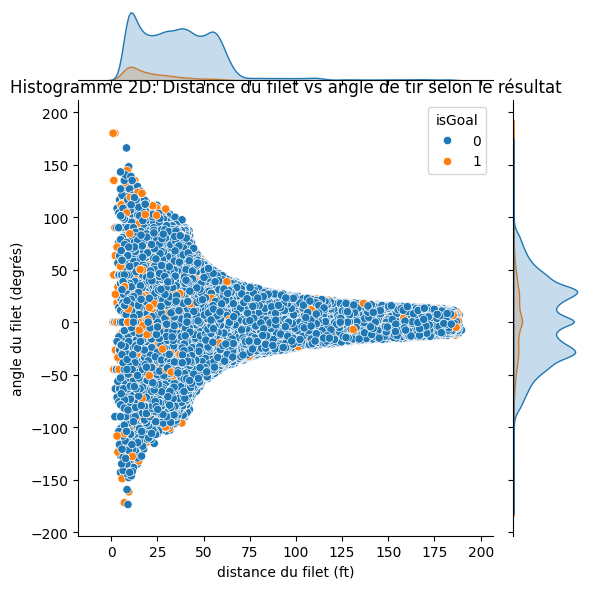

In [40]:
sns.jointplot(data=train_data, x="distance", y="angle", hue="isGoal")\
    .set_axis_labels("distance du filet (ft)", "angle du filet (degrés)")
plt.tight_layout()
plt.title("Histogramme 2D: Distance du filet vs angle de tir selon le résultat")
plt.savefig('../figures/Milestone_2/hist_2d_distance_vs_angle_selon_resultat.png')

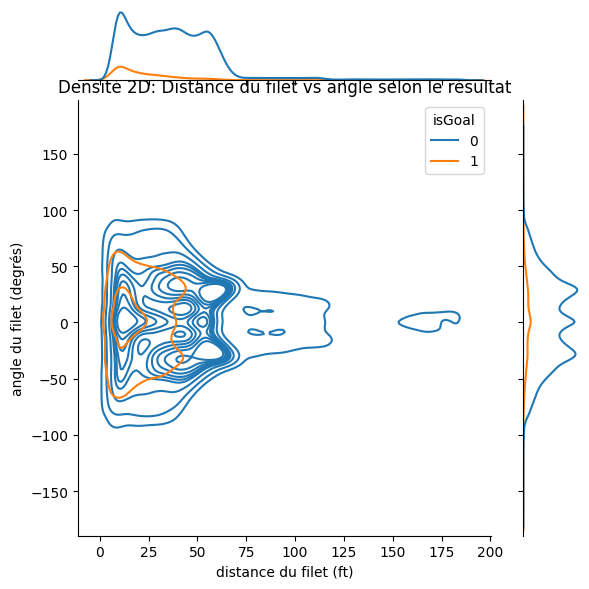

In [41]:
sns.jointplot(data=train_data, x="distance", y="angle", hue="isGoal", kind="kde")\
    .set_axis_labels("distance du filet (ft)", "angle du filet (degrés)")

plt.tight_layout()
plt.title("Densité 2D: Distance du filet vs angle selon le résultat")
plt.savefig('../figures/Milestone_2/dens_2d_distance_vs_angle_selon_resultat.png')

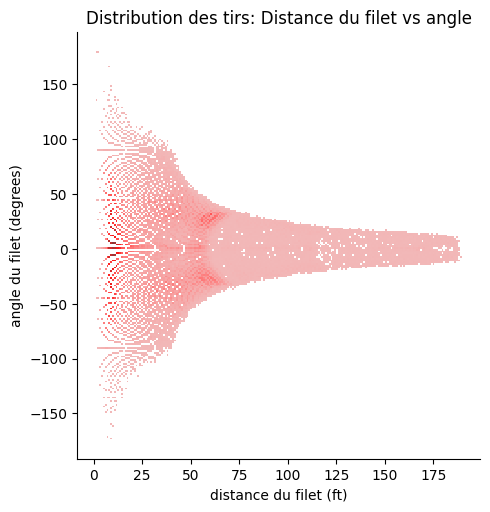

In [42]:
sns.displot(train_data,x='distance',y='angle', color = 'red').set(xlabel='distance du filet (ft)', ylabel='angle du filet (degrees)')
plt.tight_layout()

plt.title("Distribution des tirs: Distance du filet vs angle")
plt.savefig('../figures/Milestone_2/distribution_des_tirs.png')

## Question 2:

Deux figures reliant le taux de but, c'est-à-dire #buts / (#pas_de_buts + #buts), à la distance et le taux de but à l'angle du tir. Incluez ces figures dans votre article de blog et discutez brièvement de vos observations. 

/var/folders/t2/9c8bj37s0nj1yw_vzddmjy7c0000gn/T/ipykernel_62374/68284089.py:13: RuntimeWarning: invalid value encountered in divide
  goal_rate_hist = np.nan_to_num(goal_hist / all_hist)


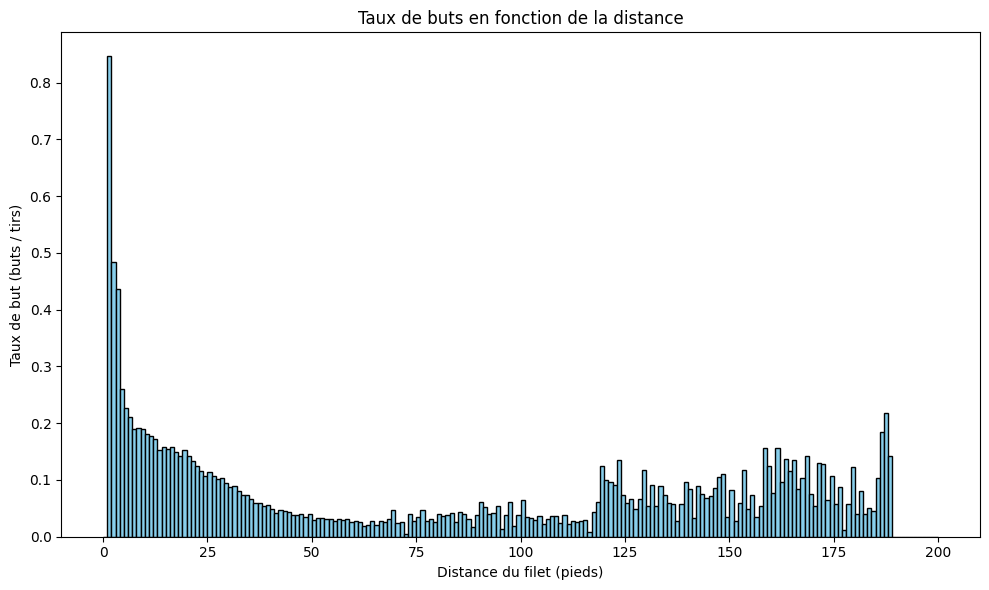

<Figure size 640x480 with 0 Axes>

In [43]:
# Figure donnant taux de but, c'est-à-dire #buts / (#pas_de_buts + #buts), à la distance  

import numpy as np
import matplotlib.pyplot as plt

# Paramètres du nombre de bins
bin_num = 200

# Taux de buts par distance
goal_hist, goal_bins = np.histogram(train_data[train_data['isGoal'] == 1]['distance'], bins=bin_num, range=(0, 200))
all_hist, all_bins = np.histogram(train_data['distance'], bins=bin_num, range=(0, 200))

goal_rate_hist = np.nan_to_num(goal_hist / all_hist)

plt.figure(figsize=(10, 6))
plt.hist(goal_bins[:-1], goal_bins, weights=goal_rate_hist, color='skyblue', edgecolor='black')
plt.xlabel('Distance du filet (pieds)')
plt.ylabel('Taux de but (buts / tirs)')
plt.title("Taux de buts en fonction de la distance")
plt.tight_layout()
plt.show()
plt.savefig('../figures/Milestone_2/2-2a_goal_rate_dist.png')  


/var/folders/t2/9c8bj37s0nj1yw_vzddmjy7c0000gn/T/ipykernel_62374/626854858.py:6: RuntimeWarning: invalid value encountered in divide
  goal_rate_hist = np.nan_to_num(goal_hist / all_hist)


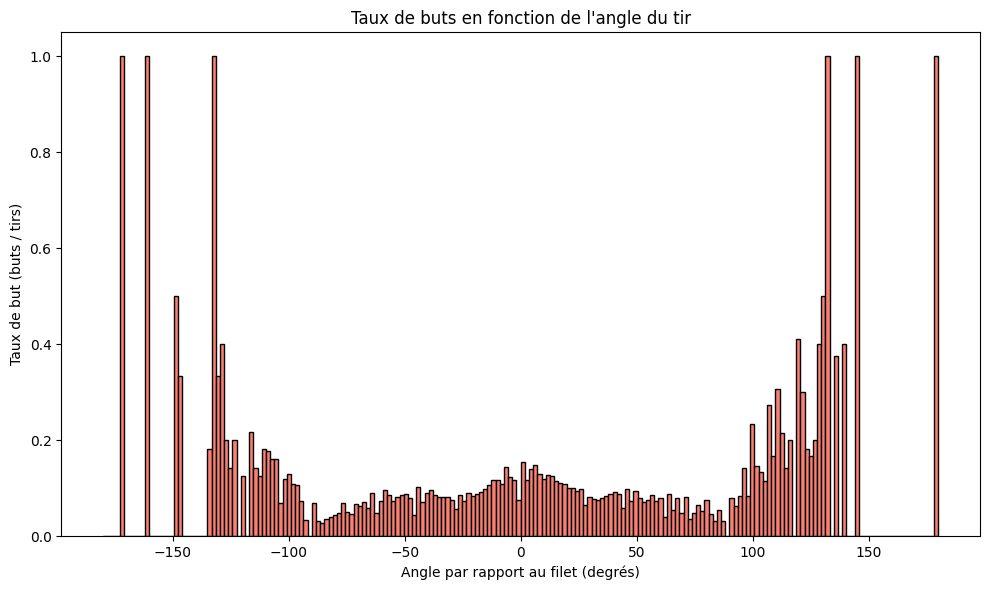

<Figure size 640x480 with 0 Axes>

In [44]:
# Taux de buts par angle
bin_num = 200
goal_hist, goal_bins = np.histogram(train_data[train_data['isGoal'] == 1]['angle'], bins=bin_num, range=(-180.0, 180.0))
all_hist, all_bins = np.histogram(train_data['angle'], bins=bin_num, range=(-180.0, 180.0))

goal_rate_hist = np.nan_to_num(goal_hist / all_hist)

plt.figure(figsize=(10, 6))
plt.hist(goal_bins[:-1], goal_bins, weights=goal_rate_hist, color='salmon', edgecolor='black')
plt.xlabel('Angle par rapport au filet (degrés)')
plt.ylabel('Taux de but (buts / tirs)')
plt.title("Taux de buts en fonction de l'angle du tir")
plt.tight_layout()
plt.show()
plt.savefig('../figures/Milestone_2/2-2b_goal_rate_angle.png') 

Question 3:

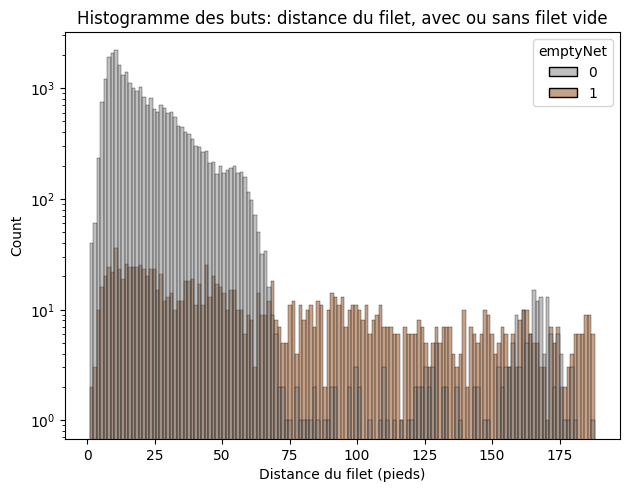

In [45]:
# Histogramme prenant en compte que les buts, regroupés par distance, et en séparant les événements avec filet vide et sans filet vide.

sns.histplot(data=train_data[train_data['isGoal'] == 1], x='distance', hue='emptyNet', palette=['#808080', '#8B4513']).set(xlabel='Distance du filet (pieds)', ylabel='Count')
plt.yscale('log')
plt.tight_layout()

plt.title("Histogramme des buts: distance du filet, avec ou sans filet vide")
plt.savefig('../figures/Milestone_2/hist_buts_distance_du_filet.png')


Autre figure possible

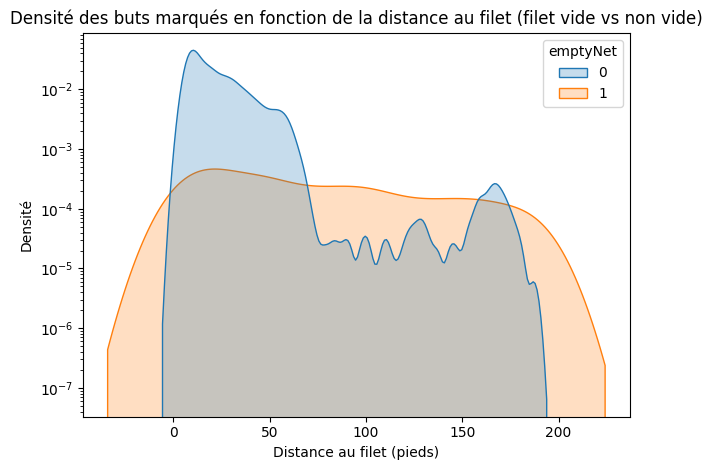

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer une courbe de densité pour les buts marqués, séparée par l'état du filet
sns.kdeplot(data=train_data[train_data['isGoal'] == 1], x='distance', hue='emptyNet', fill=True, palette=['#1f77b4', '#ff7f0e'])
plt.yscale('log')
plt.xlabel('Distance au filet (pieds)')
plt.ylabel('Densité')
plt.title('Densité des buts marqués en fonction de la distance au filet (filet vide vs non vide)')
plt.tight_layout()
plt.savefig('../figures/Milestone_2/densite_des_bus_en_function_de_distance_au_filet.png')
plt.show()

In [47]:

# Verifier qu'il est extremement rare de marquer un but sur un filet non vide contre l'équipe adverse depuis sa propre zone défensive 
# Définition : la zone défensive est située à 60 pieds du but le plus proche (le but de l'équipe) ou à 75 pieds des bandes
but_extreme_filet_occupe = train_data[(train_data['distance'] > 120) & (train_data['emptyNet'] == 0) & (train_data['isGoal'] == 1)]
print(but_extreme_filet_occupe.tail(20))
unique_game_ids = but_extreme_filet_occupe['gameID'].unique()
print(unique_game_ids)

            gameID    distance    angle  isGoal  emptyNet
223434  2018020886  169.026625   1.0170       1         0
225916  2018020924  173.026010  -0.9935       1         0
226157  2018020928  171.011696   0.6701       1         0
226901  2018020940  131.461021   4.7998       1         0
227752  2018020953  171.073084  -1.6748       1         0
231319  2018021009  162.151164  -2.4742       1         0
232296  2018021024  165.003030  -0.3472       1         0
232328  2018021024  172.142383  -2.3305       1         0
235310  2018021073  153.574086  10.5051       1         0
237687  2018021110  171.143215   2.3441       1         0
238783  2018021127  179.136819  -2.2395       1         0
243418  2018021201  168.000000   0.0000       1         0
243451  2018021202  181.107703  -6.3402       1         0
246162  2018021244  169.047331  -1.3559       1         0
250564  2018030182  162.000000   0.0000       1         0
257444  2019020063  129.711218   9.3171       1         0
259499  201902